In [1]:
# 自动计算cell的计算时间
%load_ext autotime

%config InlineBackend.figure_format='svg' #矢量图设置，让绘图更清晰

time: 13 ms (started: 2021-08-11 11:50:14 +08:00)


In [13]:
%%bash

# 增加更新
git add *.ipynb

git remote -v

git commit -m '更新 ch2 #2 change Aug 11, 2021'

git push origin master

origin	git@github.com:ustchope/Advanced-Deep-Learning-with-Keras.git (fetch)
origin	git@github.com:ustchope/Advanced-Deep-Learning-with-Keras.git (push)
[master 2ba0299] 更新 ch3 #1 change Aug 11, 2021
 1 file changed, 955 insertions(+), 3 deletions(-)


To git@github.com:ustchope/Advanced-Deep-Learning-with-Keras.git
   d8a7b3f..2ba0299  master -> master


time: 4.9 s (started: 2021-08-11 11:42:17 +08:00)


In [2]:
#设置使用的gpu
import tensorflow as tf

gpus = tf.config.list_physical_devices("GPU")

if gpus:
   
    gpu0 = gpus[0] #如果有多个GPU，仅使用第0个GPU
    tf.config.experimental.set_memory_growth(gpu0, True) #设置GPU显存用量按需使用
    # 或者也可以设置GPU显存为固定使用量(例如：4G)
    #tf.config.experimental.set_virtual_device_configuration(gpu0,
    #    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)]) 
    tf.config.set_visible_devices([gpu0],"GPU")

time: 3.58 s (started: 2021-08-11 11:50:18 +08:00)


# 深度神经网络

在本章中，我们将研究深度神经网络。 这些网络在 ImageNet、CIFAR10 (https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf) 等更具挑战性的数据集上的分类准确性方面表现出色 CIFAR100。 为简洁起见，我们将只关注两个网络：ResNet 和 DenseNet。 虽然我们将详细介绍，但花点时间介绍这些网络很重要。

ResNet 引入了残差学习的概念，这使它能够通过解决深度卷积网络中的梯度消失问题（在第 2 节中讨论）来构建非常深的网络。
DenseNet 通过允许每个卷积直接访问输入和较低层的特征图，进一步改进了 ResNet。 通过利用瓶颈层和过渡层，它还设法将深度网络中的参数数量保持在较低水平。

但为什么是这两个模型，而不是其他模型？ 嗯，自从它们被引入以来，已经有无数模型，例如 ResNeXt [6] 和 WideResNet，它们受到这两个网络使用的技术的启发。 同样，通过对 ResNet 和 DenseNet 的理解，我们将能够使用他们的设计指南来构建我们自己的模型。 通过使用迁移学习，这也将使我们能够将预训练的 ResNet 和 DenseNet 模型用于我们自己的目的，例如对象检测和分割。 仅这些原因，再加上它们与 Keras 的兼容性，就使这两个模型成为探索和补充本书高级深度学习范围的理想选择。

虽然本章的重点是深度神经网络； 我们将通过讨论 Keras 的一个重要特性（称为函数式 API）来开始本章。 此 API 充当在 tf.keras 中构建网络的替代方法，使我们能够构建序列模型 API 无法完成的更复杂的网络。 我们如此关注这个 API 的原因是它将成为构建深度网络的一个非常有用的工具，比如我们在本章中关注的两个。 建议您在进入本章之前完成第 1 章，介绍使用 Keras 进行高级深度学习，因为我们将参考该章节中探索的介绍级代码和概念，以便在本章中将它们带到高级级别。

本章的目标是介绍：
* Keras 中的函数式 API，以及探索运行它的网络示例
* tf.keras 中的深度残差网络（ResNet 版本 1 和 2）实现
* 密集连接卷积网络 (DenseNet) 在 tf.keras 中的实现
* 探索两种流行的深度学习模型，ResNet 和 DenseNet

让我们从讨论函数式 API 开始。

## 函数式API

在我们在第 1 章介绍使用 Keras 的高级深度学习中首次介绍的序列模型 API 中，一层堆叠在另一层之上。 通常，模型将通过其输入和输出层访问。 我们还了解到，如果我们发现自己想要在网络中间添加一个辅助输入，甚至在最后一层之前提取一个辅助输出，则没有简单的机制。

该模型也有其缺点。 例如，它不支持类似图形的模型或行为类似于 Python 函数的模型。 此外，在两个模型之间共享层也很困难。 Functional API 解决了这些限制，这也是为什么它是任何想要使用深度学习模型的人的重要工具的原因。

Functional API 由以下两个概念指导：
* 层是一个接受张量作为参数的实例。 一层的输出是另一个张量。 为了构建模型，层实例是通过输入和输出张量相互链接的对象。 这将产生与在 Sequential 模型中堆叠多个层类似的最终结果。 但是，使用层实例使模型更容易拥有辅助或多个输入和输出，因为每个层的输入/输出都可以轻松访问。
* 模型是一个或多个输入张量和输出张量之间的函数。 在模型输入和输出之间，张量是通过层输入和输出张量相互链接的层实例。 因此，模型是一个或多个输入层和一个或多个输出层的函数。 模型实例将关于数据如何从输入流向输出的计算图形式化。

完成 Functional API 模型的构建后，训练和评估将由 Sequential 模型中使用的相同函数执行。 为了说明，在函数式 API 中，一个二维卷积层 Conv2D，具有 32 个过滤器，x 作为层输入张量，y 作为层输出张量，可以写成：

In [ ]:
y = Conv2D(32)(x)

我们还能够堆叠多个层来构建我们的模型。 例如，我们可以使用功能 API 在 MNIST cnn-mnist-1.4.1.py 上重写卷积神经网络 (CNN)，如下面的清单所示：

> 清单 2.1.1：cnn-functional-2.1.1.py

In [5]:
''' Using Functional API to build CNN

~99.3% test accuracy
'''

import numpy as np
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical


# load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# from sparse label to categorical
num_labels = len(np.unique(y_train))
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# reshape and normalize input images
image_size = x_train.shape[1]
x_train = np.reshape(x_train,[-1, image_size, image_size, 1])
x_test = np.reshape(x_test,[-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# network parameters
input_shape = (image_size, image_size, 1)
batch_size = 128
kernel_size = 3
filters = 64
dropout = 0.3

# use functional API to build cnn layers
inputs = Input(shape=input_shape)
y = Conv2D(filters=filters,
           kernel_size=kernel_size,
           activation='relu')(inputs)
y = MaxPooling2D()(y)
y = Conv2D(filters=filters,
           kernel_size=kernel_size,
           activation='relu')(y)
y = MaxPooling2D()(y)
y = Conv2D(filters=filters,
           kernel_size=kernel_size,
           activation='relu')(y)
# image to vector before connecting to dense layer
y = Flatten()(y)
# dropout regularization
y = Dropout(dropout)(y)
outputs = Dense(num_labels, activation='softmax')(y)

# build the model by supplying inputs/outputs
model = Model(inputs=inputs, outputs=outputs)
# network model in text
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 576)               0     

In [6]:
# classifier loss, Adam optimizer, classifier accuracy
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# train the model with input images and labels
model.fit(x_train,
          y_train,
          validation_data=(x_test, y_test),
          epochs=20,
          batch_size=batch_size)

Epoch 1/20
469/469 [==============================] - 17s 19ms/step - loss: 0.2612 - accuracy: 0.9211 - val_loss: 0.0539 - val_accuracy: 0.9834
Epoch 2/20
469/469 [==============================] - 7s 15ms/step - loss: 0.0697 - accuracy: 0.9785 - val_loss: 0.0358 - val_accuracy: 0.9886
Epoch 3/20
469/469 [==============================] - 7s 15ms/step - loss: 0.0500 - accuracy: 0.9841 - val_loss: 0.0283 - val_accuracy: 0.9904
Epoch 4/20
469/469 [==============================] - 7s 14ms/step - loss: 0.0398 - accuracy: 0.9876 - val_loss: 0.0325 - val_accuracy: 0.9894
Epoch 5/20
469/469 [==============================] - 7s 15ms/step - loss: 0.0346 - accuracy: 0.9888 - val_loss: 0.0270 - val_accuracy: 0.9916
Epoch 6/20
469/469 [==============================] - 7s 14ms/step - loss: 0.0286 - accuracy: 0.9906 - val_loss: 0.0287 - val_accuracy: 0.9902
Epoch 7/20
469/469 [==============================] - 7s 15ms/step - loss: 0.0272 - accuracy: 0.9911 - val_loss: 0.0249 - val_accuracy: 0.991

time: 2min 28s (started: 2021-08-11 11:14:52 +08:00)


In [7]:
# model accuracy on test dataset
score = model.evaluate(x_test,
                       y_test,
                       batch_size=batch_size,
                       verbose=0)
print("\nTest accuracy: %.1f%%" % (100.0 * score[1]))


Test accuracy: 99.3%
time: 895 ms (started: 2021-08-11 11:18:16 +08:00)


默认情况下，MaxPooling2D 使用 pool_size=2，因此该参数已被删除。

在前面的清单中，每一层都是张量的函数。 每层生成一个张量作为输出，该张量成为下一层的输入。 为了创建这个模型，我们可以调用 Model() 并提供输入和输出张量，或者张量列表。 其他一切都保持不变。

同样的列表也可以使用 fit() 和 evaluate() 函数进行训练和评估，类似于 Sequential 模型。 Sequential 类实际上是 Model 类的子类。 我们需要记住，我们在 fit() 函数中插入了 validation_data 参数，以查看训练期间验证准确性的进展。 准确率在 20 个 epoch 中从 99.3% 到 99.4% 不等。

### 创建二输入一输出模型

![](https://tva1.sinaimg.cn/large/008i3skNgy1gtcaqlbq7oj30yg0pmmzi.jpg)我们现在要做一些非常令人兴奋的事情，创建一个具有两个输入和一个输出的高级模型。 在我们开始之前，重要的是要知道 Sequential 模型 API 仅用于构建 1-input 和 1-output 模型。

假设发明了一种用于 MNIST 数字分类的新模型，称为 Y 网络，如图 2.1.1 所示。 Y-Network 在左右 CNN 分支上使用相同的输入两次。 网络使用连接层组合结果。 合并操作 concatenate 类似于将两个形状相同的张量沿串联轴堆叠以形成一个张量。 例如，沿最后一个轴连接两个形状为 (3, 3, 16) 的张量将产生形状为 (3, 3, 32) 的张量。

连接层之后的其他所有内容都将与前一章的 CNN MNIST 分类器模型相同：Flatten，然后是 Dropout，然后是 Dense：

![](https://tva1.sinaimg.cn/large/008i3skNgy1gtcaqlbq7oj30yg0pmmzi.jpg)

为了提高代码清单 2.1.1 中模型的性能，我们可以提出几个变化。首先，Y-Network 的分支将过滤器的数量加倍，以补偿 MaxPooling2D() 之后特征图大小的减半。例如，如果第一个卷积的输出是 (28, 28, 32)，则最大池化后的新形状是 (14, 14, 32)。下一个卷积的过滤器大小为 64，输出维度为 (14, 14, 64)。

其次，尽管两个分支的内核大小相同，均为 3，但右分支使用的扩张率为 2。图 2.1.2 显示了不同扩张率对大小为 3 的内核的影响。使用膨胀率确定内核的字段大小，CNN 将启用正确的分支来学习不同的特征图。使用大于 1 的扩张率是一种在计算上有效的近似方法来增加感受野大小。它是近似的，因为内核实际上并不是一个成熟的内核。它是有效的，因为我们使用的操作次数与膨胀率等于 1 的次数相同。

要理解感受野的概念，请注意，当内核计算特征图的每个点时，它的输入是前一层特征图中的一个补丁，它也依赖于其前一层特征图。 如果我们继续跟踪这种依赖到输入图像，内核依赖于称为感受野的图像块。

我们将使用选项 padding='same' 来确保在使用扩张的 CNN 时我们不会有负张量维度。 通过使用 padding='same'，我们将保持输入的维度与输出特征图的维度相同。 这是通过用零填充输入以确保输出具有相同大小来实现的。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gtcaucsq2cj31ds0ioq4t.jpg)

cnn-y-network-2.1.2.py 的清单 2.1.2 显示了使用功能 API 实现 Y-Network。 这两个分支由两个 for 循环创建。 两个分支都期望相同的输入形状。 这两个 for 循环将创建两个 3 层的 Conv2D-Dropout-MaxPooling2D 堆栈。 虽然我们使用连接层来组合左右分支的输出，但我们也可以利用 tf.keras 的其他合并功能，例如加、点和乘。 合并函数的选择并非完全随意，而是必须基于合理的模型设计决策。

在 Y-Network 中，concatenate 不会丢弃特征图的任何部分。 相反，我们将让 Dense 层弄清楚如何处理连接的特征图。

> 清单 2.1.2：cnn-y-network-2.1.2.py

In [8]:
'''Implements a Y-Network using Functional API

~99.3% test accuracy
'''


import numpy as np

from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Flatten, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model

# load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# from sparse label to categorical
num_labels = len(np.unique(y_train))
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# reshape and normalize input images
image_size = x_train.shape[1]
x_train = np.reshape(x_train,[-1, image_size, image_size, 1])
x_test = np.reshape(x_test,[-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# network parameters
input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3
dropout = 0.4
n_filters = 32

# left branch of Y network
left_inputs = Input(shape=input_shape)
x = left_inputs
filters = n_filters
# 3 layers of Conv2D-Dropout-MaxPooling2D
# number of filters doubles after each layer (32-64-128)
for i in range(3):
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               padding='same',
               activation='relu')(x)
    x = Dropout(dropout)(x)
    x = MaxPooling2D()(x)
    filters *= 2

# right branch of Y network
right_inputs = Input(shape=input_shape)
y = right_inputs
filters = n_filters
# 3 layers of Conv2D-Dropout-MaxPooling2D
# number of filters doubles after each layer (32-64-128)
for i in range(3):
    y = Conv2D(filters=filters,
               kernel_size=kernel_size,
               padding='same',
               activation='relu',
               dilation_rate=2)(y)
    y = Dropout(dropout)(y)
    y = MaxPooling2D()(y)
    filters *= 2

# merge left and right branches outputs
y = concatenate([x, y])
# feature maps to vector before connecting to Dense 
y = Flatten()(y)
y = Dropout(dropout)(y)
outputs = Dense(num_labels, activation='softmax')(y)

# build the model in functional API
model = Model([left_inputs, right_inputs], outputs)

# verify the model using graph
# enable this if pydot can be installed
# pip install pydot
#plot_model(model, to_file='cnn-y-network.png', show_shapes=True)

# verify the model using layer text description
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 28, 28, 32)   320         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 28, 28, 32)   320         input_3[0][0]                    
____________________________________________________________________________________________

In [9]:
# classifier loss, Adam optimizer, classifier accuracy
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# train the model with input images and labels
model.fit([x_train, x_train],
          y_train, 
          validation_data=([x_test, x_test], y_test),
          epochs=20,
          batch_size=batch_size)

Epoch 1/20
1875/1875 [==============================] - 26s 12ms/step - loss: 0.1775 - accuracy: 0.9458 - val_loss: 0.1641 - val_accuracy: 0.9854
Epoch 2/20
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0664 - accuracy: 0.9796 - val_loss: 0.0945 - val_accuracy: 0.9892
Epoch 3/20
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0534 - accuracy: 0.9831 - val_loss: 0.0721 - val_accuracy: 0.9921
Epoch 4/20
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0465 - accuracy: 0.9855 - val_loss: 0.0761 - val_accuracy: 0.9912
Epoch 5/20
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0424 - accuracy: 0.9871 - val_loss: 0.0478 - val_accuracy: 0.9936
Epoch 6/20
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0387 - accuracy: 0.9878 - val_loss: 0.0386 - val_accuracy: 0.9926
Epoch 7/20
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0378 - accuracy: 0.9879 - val_loss: 0.0426 -

time: 7min 20s (started: 2021-08-11 11:28:49 +08:00)


In [10]:
# model accuracy on test dataset
score = model.evaluate([x_test, x_test],
                       y_test,
                       batch_size=batch_size,
                       verbose=0)
print("\nTest accuracy: %.1f%%" % (100.0 * score[1]))


Test accuracy: 99.2%
time: 3.88 s (started: 2021-08-11 11:36:09 +08:00)


退一步，我们可以注意到 Y-Network 需要两个输入用于训练和验证。 输入是相同的，因此提供了 [x_train, x_train]。

在 20 个 epoch 的过程中，Y-Network 的准确率从 99.4% 到 99.5% 不等。 这比 3-stack CNN 略有改进，后者实现了 99.3% 到 99.4% 的准确率。 然而，这是以更高的成本为代价的
复杂性和参数数量的两倍以上。

下图，图 2.1.3，显示了 Keras 理解的并由 plot_model() 函数生成的 Y 网络架构：

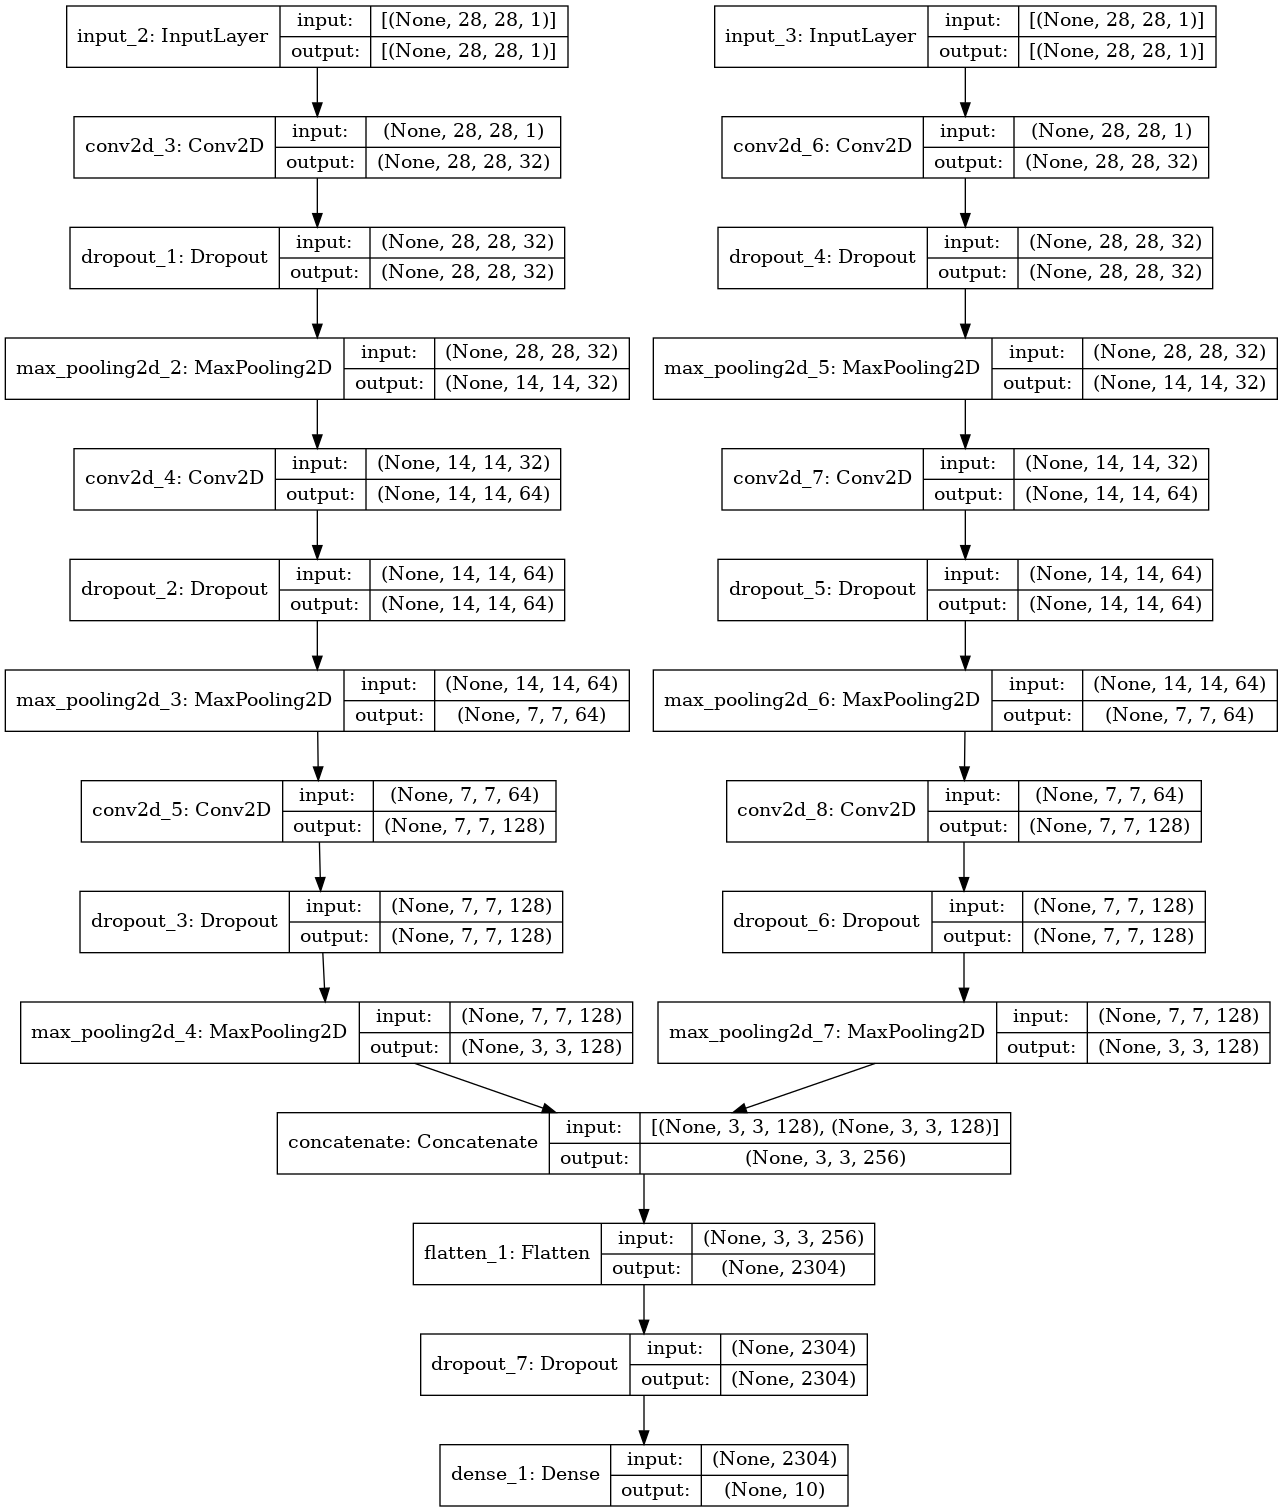

time: 607 ms (started: 2021-08-11 11:36:51 +08:00)


In [12]:
 plot_model(model, show_shapes=True)

我们对 Functional API 的研究到此结束。 我们应该花时间记住本章的重点是构建深度神经网络，特别是 ResNet 和 DenseNet。 因此，我们只涵盖构建它们所需的函数式 API 材料，因为涵盖整个 API 超出了本书的范围。 话虽如此，让我们继续讨论 ResNet。

## 深度残差网络 (ResNet)

深度网络的一个关键优势是它们具有从输入和特征图学习不同级别表示的强大能力。在分类、分割、检测和许多其他计算机视觉问题中，学习不同的特征图通常会带来更好的性能。

但是，您会发现训练深度网络并不容易，因为在反向传播期间梯度可能会随着浅层深度的增加而消失（或爆炸）。图 2.2.1 说明了梯度消失的问题。网络参数通过从输出层到所有先前层的反向传播进行更新。由于反向传播基于链式法则，梯度到达浅层时有减小的趋势。这是由于小数的乘法，特别是对于小损失函数和参数值。

乘法运算的次数将与网络的深度成正比。还值得注意的是，如果梯度下降，参数将不会适当更新。

因此，网络将无法提高其性能。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gtcb4q749oj30x20l80tt.jpg)

为了缓解深度网络中梯度的退化，ResNet 引入了深度残差学习框架的概念。 让我们分析一个区块：我们深层网络的一小部分。

图 2.2.2 显示了典型 CNN 块和 ResNet 残差块之间的比较。 ResNet 的思想是为了防止梯度下降，我们让信息通过快捷连接到达浅层。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gtcb68succj318o0gywg3.jpg)

接下来，我们将在讨论两个块之间的差异时查看更多细节。 图 2.2.3 显示了另一个常用深度网络 VGG [3] 和 ResNet 的 CNN 块的更多细节。 我们将层特征图表示为 $x$。 第 $l$ 层的特征图是 $x_l$。 CNN层中的操作是`Conv2D-Batch Normalization(BN)-ReLU`。

假设我们以 H() = Conv2D-Batch Normalization(BN)-ReLU 的形式表示这组操作； 然后：

![](https://tva1.sinaimg.cn/large/008i3skNgy1gtcb9ubxrcj315y04yjrj.jpg)

换句话说，第l-2层的特征图被转换为$x_{l-1}$ 通过 H() = Conv2D-批量归一化(BN)-ReLU。 应用相同的一组操作将 $x_{l-1}$ 转换为 $x_l$。 换句话说，如果我们有一个 18 层的 VGG，那么在输入图像被转换为第 18 层特征图之前有 18 次 H() 操作。

一般而言，我们可以观察到第 l 层输出的特征图仅直接受先前特征图的影响。 同时，对于 ResNet：

![](https://tva1.sinaimg.cn/large/008i3skNgy1gtcbc80j94j316e04saaa.jpg)

![](https://tva1.sinaimg.cn/large/008i3skNgy1gtcbchd3pwj31900muwg3.jpg)